In [1]:
import time
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import multiprocessing
from itertools import repeat, product
import matplotlib.pyplot as plt


import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer



random.seed(42)
%matplotlib inline

# Load the data

In [2]:
twenty_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)

In [3]:
len(twenty_train.data)

11314

In [4]:
twenty_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

# modeling

In [5]:
X, y = twenty_train.data, twenty_train.target

In [6]:
vectorizer = CountVectorizer(lowercase=False, ngram_range=(1,2))

X = vectorizer.fit_transform(X)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [8]:
n_jobs = [
    multiprocessing.cpu_count() // 2,
    -1,
    1
]

tree_method = ["exact", 
               "hist"
              ] # https://xgboost.readthedocs.io/en/latest/treemethod.html#approximated-solutions

param_space = list(product(n_jobs, tree_method))

In [9]:
param_space

[(4, 'exact'),
 (4, 'hist'),
 (-1, 'exact'),
 (-1, 'hist'),
 (1, 'exact'),
 (1, 'hist')]

In [10]:
num_exp = 50
all_exps = []


for n, t in param_space:
    exp_time = []
    exp_score = []
    experiment_dict ={}
    experiment_dict["method"] = f"n_job={n}, tree_method={t}"   
    
    print(f"n_job={n}, tree_method={t} x {num_exp} times")
    
    for i in tqdm(repeat(1, num_exp), total=num_exp):
        
        xgb_model = xgb.XGBClassifier(n_jobs=n,
                                      tree_method=t,
                                      n_estimators=100, 
                                      random_state=42
                                     )
        
        
        text_clf = Pipeline([
            # ('vect', CountVectorizer(lowercase=False, ngram_range=(1,2))),
            ('clf', xgb_model)
        ])

        start = time.time()
        text_clf.fit(X_train, y_train)
        end = time.time()
        exp_time.append(end-start)
        
        y_pred = text_clf.predict(X_test)
        score = f1_score(y_test, y_pred, average='macro')
        exp_score.append(score)
        # print(score)
    
    experiment_dict["time_result"] = exp_time
    experiment_dict["average_score"] = exp_score
    
    all_exps.append(experiment_dict)

n_job=4, tree_method=exact x 50 times


100%|██████████| 50/50 [4:13:00<00:00, 303.62s/it]  


n_job=4, tree_method=hist x 50 times


100%|██████████| 50/50 [6:24:11<00:00, 461.03s/it]  


n_job=-1, tree_method=exact x 50 times


100%|██████████| 50/50 [3:15:02<00:00, 234.06s/it]  


n_job=-1, tree_method=hist x 50 times


100%|██████████| 50/50 [5:49:21<00:00, 419.23s/it]  


n_job=1, tree_method=exact x 50 times


100%|██████████| 50/50 [14:36:25<00:00, 1051.72s/it]  


n_job=1, tree_method=hist x 50 times


100%|██████████| 50/50 [16:59:16<00:00, 1223.13s/it]  


In [11]:
all_exps

[{'method': 'n_job=4, tree_method=exact',
  'time_result': [293.35462498664856,
   312.37032103538513,
   323.19646525382996,
   325.78525471687317,
   334.7098741531372,
   331.1160349845886,
   319.74588894844055,
   304.170156955719,
   297.75962924957275,
   302.9052941799164,
   304.70632219314575,
   309.4521563053131,
   306.25667786598206,
   304.7890281677246,
   304.23427414894104,
   298.9260139465332,
   294.1267340183258,
   298.24998712539673,
   297.2469198703766,
   297.95790696144104,
   299.77945017814636,
   300.1146082878113,
   300.08959197998047,
   299.37154030799866,
   300.04026794433594,
   301.05499386787415,
   299.98308205604553,
   299.0884921550751,
   299.74896597862244,
   300.08196997642517,
   299.3168752193451,
   299.61594820022583,
   300.2806570529938,
   303.53759002685547,
   301.31120204925537,
   302.1905469894409,
   302.75060176849365,
   300.00273990631104,
   298.4110701084137,
   299.08758902549744,
   299.6099228858948,
   299.6390278339

### sklearn with Ray backend

In [ ]:
import joblib
from ray.util.joblib import register_ray
register_ray()

In [ ]:
exp_time = []
experiment_dict ={}
for n_est in n_estimators:
    experiment_dict["method"] = f"ray backend, n_est={n_est}"
    xgb_model = xgb.XGBClassifier(
    #n_jobs=-1,
    tree_method='exact',
    n_estimators=100, 
    random_state=123
    )


    text_clf = Pipeline([
        # ('vect', CountVectorizer(lowercase=False, ngram_range=(1,2))),
        ('clf', xgb_model)
    ])
    for i in tqdm(repeat(1, num_exp), total=num_exp):
        with joblib.parallel_backend('ray'):        
            start = time.time()
            text_clf.fit(X_train, y_train)
            end = time.time()
        exp_time.append(end-start)
    experiment_dict["time_result"] = exp_time

In [ ]:
all_exps.append(experiment_dict)

### Ray trainer

In [ ]:
import ray
# from ray.air.config import ScalingConfig
from ray.train.xgboost impor                         t XGBoostTrainer
# from ray.data.preprocessors import CountVectorizer

In [ ]:
df = df.dropna(subset=['preds'])
df.shape

In [ ]:
X, y = df['text'], df['preds']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123)

In [ ]:
df_ray = ray.data.read_parquet("./data/df_labeled.parquet")

df_ray = df_ray.drop_columns(cols=['context_uid',
                                          'text_embedding', 
                                          'text_truncated', 
                                          'url',
                                          'probs',
                                          'preds_str'])

In [ ]:
train_dataset, valid_dataset = df_ray.train_test_split(test_size=0.3, seed=123)


In [ ]:
train_dataset = ray.data.from_pandas(X)

In [ ]:
num_workers=2
# XGBoost specific params
params = {
    "tree_method": "exact",
    "objective": "multi:softprob",
    "eval_metric": "merror",
}

preprocessor = CountVectorizer()

trainer = XGBoostTrainer(
    scaling_config=ScalingConfig(num_workers=num_workers, use_gpu=False),
    label_column="preds",
    params=params,
    datasets={"train": train_dataset, "valid": valid_dataset},
    preprocessor=vectorizer,
    num_boost_round=100,
)

# Visualize result

In [12]:
df_result = pd.DataFrame(all_exps).set_index("method")

In [13]:
df_result

,time_result,average_score
method,,
"n_job=4, tree_method=exact","[293.35462498664856, 312.37032103538513, 323.1...","[0.8325888933054486, 0.8325888933054486, 0.832..."
"n_job=4, tree_method=hist","[462.53806018829346, 458.7789990901947, 458.55...","[0.8315309242571999, 0.8315309242571999, 0.831..."
"n_job=-1, tree_method=exact","[231.20413184165955, 231.77034091949463, 233.8...","[0.8325888933054486, 0.8325888933054486, 0.832..."
"n_job=-1, tree_method=hist","[414.09147906303406, 414.3889961242676, 414.22...","[0.8315309242571999, 0.8315309242571999, 0.831..."
"n_job=1, tree_method=exact","[1051.6339600086212, 1054.682184934616, 1050.5...","[0.8325888933054486, 0.8325888933054486, 0.832..."
"n_job=1, tree_method=hist","[1225.4195230007172, 1224.7871389389038, 1224....","[0.8315309242571999, 0.8315309242571999, 0.831..."


In [14]:
df_result.to_csv('./df_result.csv')

In [15]:
df_result['time_result_avg'] = df_result['time_result'].apply(lambda x: np.mean(x))

In [16]:
df_result = df_result.sort_values(by="time_result_avg")

In [17]:
df_result

,time_result,average_score,time_result_avg
method,,,
"n_job=-1, tree_method=exact","[231.20413184165955, 231.77034091949463, 233.8...","[0.8325888933054486, 0.8325888933054486, 0.832...",233.833133
"n_job=4, tree_method=exact","[293.35462498664856, 312.37032103538513, 323.1...","[0.8325888933054486, 0.8325888933054486, 0.832...",303.466263
"n_job=-1, tree_method=hist","[414.09147906303406, 414.3889961242676, 414.22...","[0.8315309242571999, 0.8315309242571999, 0.831...",419.011680
"n_job=4, tree_method=hist","[462.53806018829346, 458.7789990901947, 458.55...","[0.8315309242571999, 0.8315309242571999, 0.831...",460.887029
"n_job=1, tree_method=exact","[1051.6339600086212, 1054.682184934616, 1050.5...","[0.8325888933054486, 0.8325888933054486, 0.832...",1051.518388
"n_job=1, tree_method=hist","[1225.4195230007172, 1224.7871389389038, 1224....","[0.8315309242571999, 0.8315309242571999, 0.831...",1222.946797


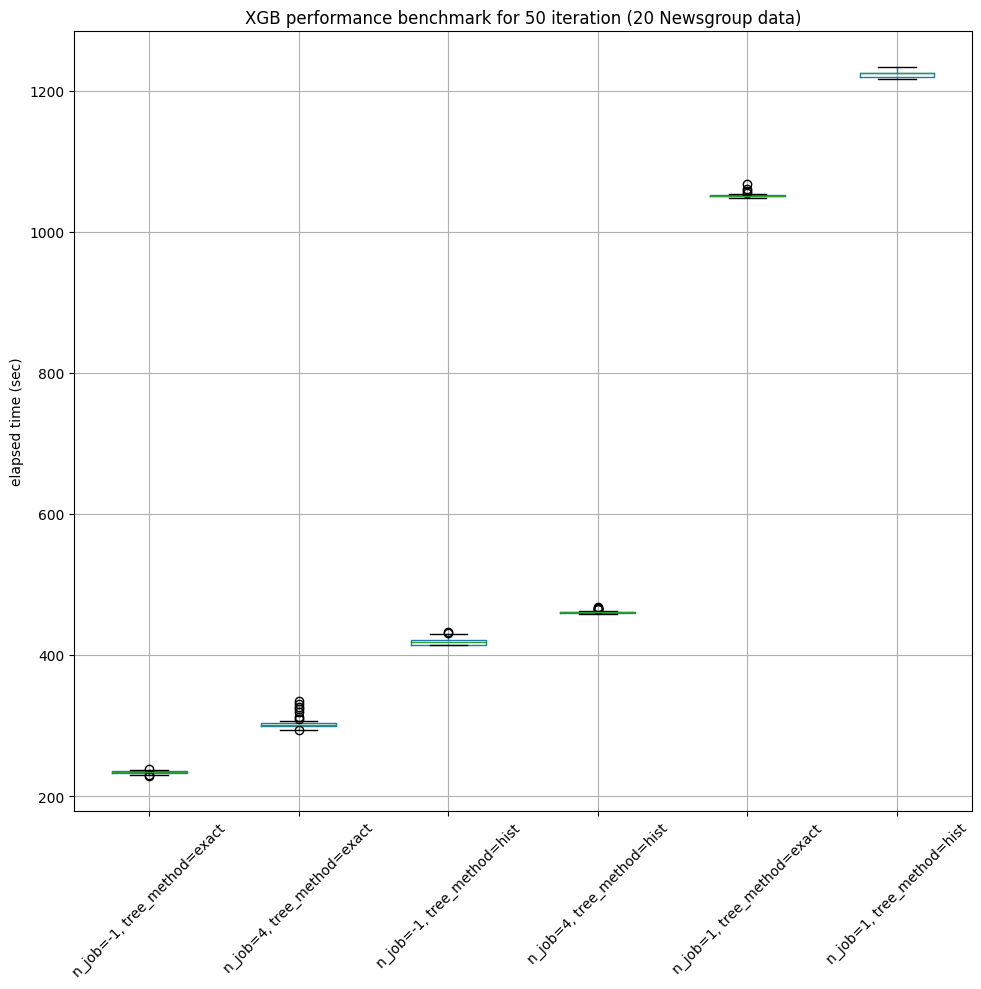

In [20]:
fig = plt.figure(figsize=(10, 10))
plt.title(f'XGB performance benchmark for {num_exp} iteration (20 Newsgroup data)')
plt.ylabel("elapsed time (sec)")
fig = df_result["time_result"].apply(lambda x: pd.Series(x)).T.boxplot(rot=45)
plt.tight_layout()
fig.figure.savefig(f'./img/performance_{num_exp}_n_estimator.png')


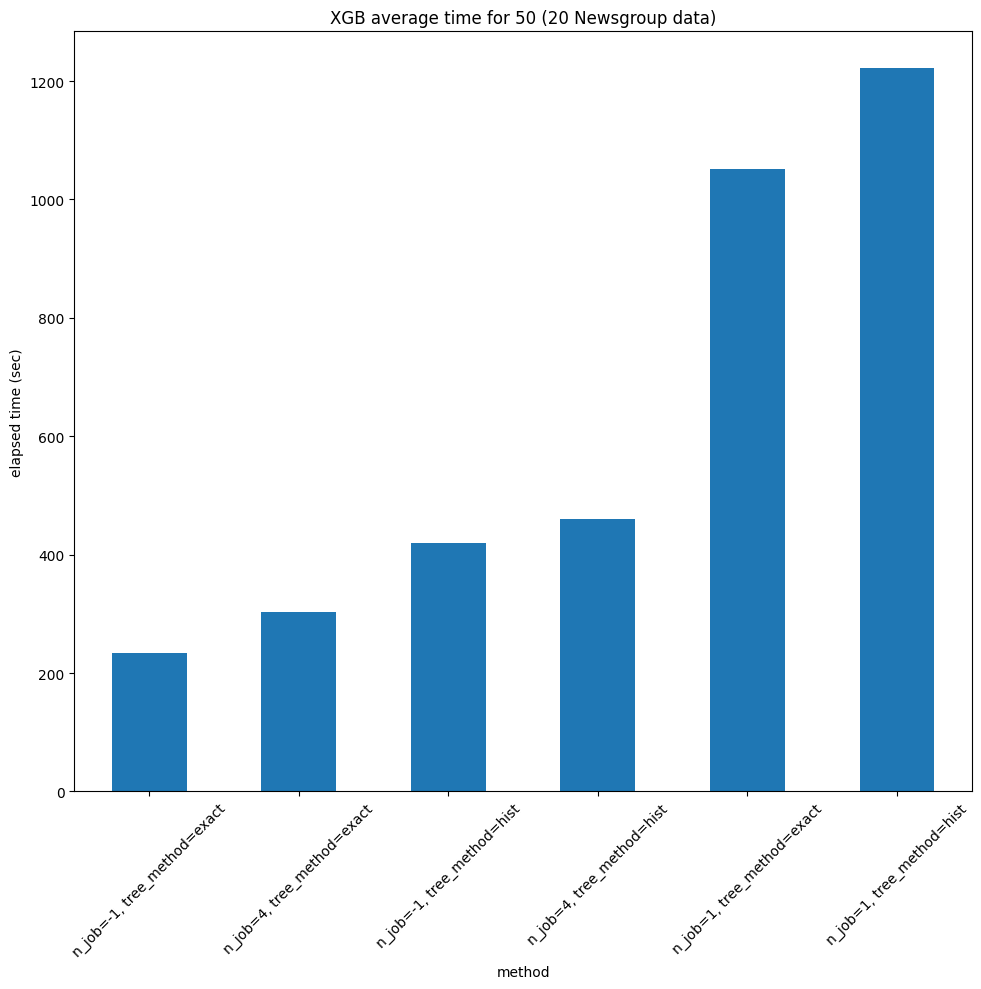

In [21]:
fig = plt.figure(figsize=(10, 10))
plt.title(f'XGB average time for {num_exp} (20 Newsgroup data)')
plt.ylabel("elapsed time (sec)")

df_result_t = df_result["time_result"].apply(lambda x: pd.Series(x)).T
fig = df_result_t.reindex(df_result_t.mean().sort_values().index, axis=1).mean().plot(kind='bar', rot=45)

plt.tight_layout()
fig.figure.savefig(f'./img/average_time_{num_exp}.png')



In [22]:
df_result

,time_result,average_score,time_result_avg
method,,,
"n_job=-1, tree_method=exact","[231.20413184165955, 231.77034091949463, 233.8...","[0.8325888933054486, 0.8325888933054486, 0.832...",233.833133
"n_job=4, tree_method=exact","[293.35462498664856, 312.37032103538513, 323.1...","[0.8325888933054486, 0.8325888933054486, 0.832...",303.466263
"n_job=-1, tree_method=hist","[414.09147906303406, 414.3889961242676, 414.22...","[0.8315309242571999, 0.8315309242571999, 0.831...",419.011680
"n_job=4, tree_method=hist","[462.53806018829346, 458.7789990901947, 458.55...","[0.8315309242571999, 0.8315309242571999, 0.831...",460.887029
"n_job=1, tree_method=exact","[1051.6339600086212, 1054.682184934616, 1050.5...","[0.8325888933054486, 0.8325888933054486, 0.832...",1051.518388
"n_job=1, tree_method=hist","[1225.4195230007172, 1224.7871389389038, 1224....","[0.8315309242571999, 0.8315309242571999, 0.831...",1222.946797


In [23]:
234/1051.5

0.2225392296718973

In [ ]:
# ray https://www.anyscale.com/blog/three-ways-to-speed-up-xgboost-model-training